# Setup



## Colab setup
---------- Start of generic setup code to get kaggle credentials login and data to work with. Copied much from Workshop 2 ----------

In [ ]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
!pip install -U -q scikeras
from google.colab import auth
from oauth2client.client import GoogleCredentials
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive

In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

https://drive.google.com/file/d/1DeYgEzZ8Bs8Y3QsHd5YsV-3D-SzVAm4x

In [ ]:
# GET data from file I've uploaded to my drive. Use your own kaggle.json and google auth logins etc
downloaded = drive.CreateFile({"id": "1DeYgEzZ8Bs8Y3QsHd5YsV-3D-SzVAm4x"})
downloaded.GetContentFile("predict-energy-consumption.zip")

In [ ]:
!unzip predict-energy-consumption.zip

!ls
!mkdir data
!mv *.csv data/

In [ ]:
from google.colab import files

files.upload()
# upload your kaggle.json file

Processing data from the source.

In [ ]:
import json

!mkdir /root/.kaggle/
!mv kaggle.json /root/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}

In [ ]:
# GENERIC SUBMIT FUNCTION (uncomment when you want to submit)

# submission = pd.DataFrame(
#    {'key': test.key, 'fare_amount': val_predictions},
#    columns = ['key', 'fare_amount'])
# submission.to_csv('submission.csv', index = False)


#!kaggle competitions submit -c predict-electricity-consumption -f submission.csv -m "[TEAM NAME] Submission"

## Libraries setup

In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sns.set()

# Data exploration

### Modification functions

In [11]:
def replaceNanWithZero(test, train, labels):
    train_labels = labels.replace(np.nan, 0.0)

    for col in train.columns:
        train[col] = train[col].replace(np.nan, 0.0)

    for col in test.columns:
        test[col] = test[col].replace(np.nan, 0.0)

    return test, train, train_labels

In [12]:
# PCA to get a lesser number of features, then going to feed into basic nn see what we can do
from sklearn.decomposition import PCA


def PCA_Performance(train, test):
    variance = [0.5, 0.6, 0.75, 0.8, 0.85, 0.9, 0.95, 0.96, 0.97, 0.98, 0.99]

    for var in variance:
        pca = PCA(n_components=var)
        pca.fit(train)
        transformed_Train = pca.transform(train)
        # transformed_Test = pca.transform(test)
        print(
            f"Retained {var} of variance with {len(transformed_Train.T)} number of features"
        )

In [13]:
def month_to_season(month: int) -> str:
    assert 1 <= month < 13
    if 3 <= month < 6:
        return "spring"
    elif 6 <= month < 9:
        return "summer"
    elif 9 <= month < 12:
        return "autumn"
    else:
        return "winter"

In [14]:
def cast_types(df: pd.DataFrame) -> pd.DataFrame:

    # Cast time, respect timezone
    df["time"] = pd.to_datetime(df["time"], utc=True).dt.tz_convert("Europe/Tallinn")

    # Cast remaining columns
    df = df.astype(
        {
            "temp": "float32",
            "dwpt": "float32",
            "rhum": "int32",
            "prcp": "float32",
            # TODO: Snow might be integer too, check it
            "snow": "float32",
            "wdir": "int32",
            "wspd": "float32",
            "wpgt": "float32",
            "pres": "float32",
            "coco": "category",
            "el_price": "float32",
        }
    )

    # Change coco categories from float to int representation
    new_categories = [int(category) for category in df["coco"].cat.categories]

    df["coco"] = df["coco"].cat.rename_categories(new_categories)

    return df

In [15]:
def explode_datetime(
    df: pd.DataFrame, datetime_column: str, without_prefix: bool = False
) -> pd.DataFrame:

    prefix = "" if without_prefix else f"{datetime_column}_"

    if f"{prefix}year" in df.columns:
        print(f"Column {prefix}year already exists")
        return df

    date_info = pd.DataFrame(
        data=[
            [x.year, x.month, x.day, x.hour, x.weekday()] for x in df[datetime_column]
        ],
        columns=[
            f"{prefix}year",
            f"{prefix}month",
            f"{prefix}day",
            f"{prefix}hour",
            f"{prefix}weekday",
        ],
    ).astype(np.int32)

    df = pd.concat([df.reset_index(), date_info], axis=1).set_index("index")

    return df

## Exploration

In [16]:
# Here we can split into train/test for verification while we train whatever works)
train = pd.read_csv("data/train.csv")
train_labels = train["consumption"]  # y vals in this case are concumption
# GIVEN time is a string we just gonna drop that mfer, cbf processing it etc

test = pd.read_csv("data/test.csv")

# Have to predict consumption for these values. Consumption unkown.
# At this point should have a train and test without Nan values:)

In [17]:
train.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,consumption
0,2021-09-01 00:00:00+03:00,11.2,10.3,94.0,NaN,NaN,320.0,7.2,16.7,1012.6,2.0,0.09016,0.577
1,2021-09-01 01:00:00+03:00,10.7,9.6,93.0,NaN,NaN,320.0,7.2,13.0,1012.6,2.0,0.09251,0.594
2,2021-09-01 02:00:00+03:00,9.9,9.0,94.0,NaN,NaN,320.0,7.2,13.0,1012.2,2.0,0.08890,0.685
3,2021-09-01 03:00:00+03:00,10.0,8.4,90.0,NaN,NaN,330.0,7.2,13.0,1011.9,1.0,0.08735,1.016
4,2021-09-01 04:00:00+03:00,9.0,8.1,94.0,NaN,NaN,300.0,3.6,13.0,1011.4,2.0,0.08688,0.677


## Preprocessing

### First look

In [18]:
train.describe()

,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,consumption
count,8592.000000,8592.000000,8592.000000,2159.000000,119.000000,8592.000000,8592.000000,8592.000000,8592.000000,8396.000000,8592.000000,8590.000000
mean,6.744204,2.486767,77.013617,0.056647,78.319328,201.564246,9.156355,20.869681,1013.229423,4.902930,0.160844,1.046364
std,9.257806,8.184391,17.520566,0.384586,63.129130,87.792064,4.826976,9.956558,12.592944,4.958744,0.120034,1.095114
min,-26.100000,-28.700000,20.000000,0.000000,0.000000,0.000000,0.000000,2.900000,962.600000,1.000000,0.000070,0.000000
25%,0.400000,-2.900000,66.000000,0.000000,20.000000,150.000000,7.200000,13.000000,1006.500000,2.000000,0.092820,0.363000
50%,6.200000,1.900000,83.000000,0.000000,60.000000,210.000000,7.200000,18.500000,1014.700000,3.000000,0.136440,0.811000
75%,13.225000,9.000000,91.000000,0.000000,130.000000,270.000000,10.800000,27.800000,1020.700000,5.000000,0.199845,1.366000
max,31.400000,20.900000,100.000000,7.900000,220.000000,360.000000,31.700000,63.000000,1047.500000,25.000000,4.000000,10.381000


In [19]:
train.isna().sum()

time              0
temp              0
dwpt              0
rhum              0
prcp           6433
snow           8473
wdir              0
wspd              0
wpgt              0
pres              0
coco            196
el_price          0
consumption       2
dtype: int64

Most missing values are for snow and precipitation

For snow it is quite a lot of data

- Delete it?
- Impute it with zero when temprature is over 0?
    - How many is left?
    
For coco it is a problem, I think this will be useful information for model

- Are the NaNs sparsely distributed?
    - If so, we can impute from the most common value in +- 2 or 3 values before and after (timeseries)f
- Can the information be found elsewhere?
    - Where is the model house located?

To the precipitation

- That is a huge problem
    - I think this data might be valuable
    - To many values missing for intelligent imputation
- Either find external source, remove it all, or impute with pure zeros
- Even if we delete it a lot of the information is stored in humidity
    - Or is it?

In [20]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8592 entries, 0 to 8591
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         8592 non-null   object 
 1   temp         8592 non-null   float64
 2   dwpt         8592 non-null   float64
 3   rhum         8592 non-null   float64
 4   prcp         2159 non-null   float64
 5   snow         119 non-null    float64
 6   wdir         8592 non-null   float64
 7   wspd         8592 non-null   float64
 8   wpgt         8592 non-null   float64
 9   pres         8592 non-null   float64
 10  coco         8396 non-null   float64
 11  el_price     8592 non-null   float64
 12  consumption  8590 non-null   float64
dtypes: float64(12), object(1)
memory usage: 872.8+ KB


In [21]:
train.loc[:, ["rhum", "wdir", "coco"]].mod(1, fill_value=0).abs().sum()

rhum    0.0
wdir    0.0
coco    0.0
dtype: float64

In [22]:
# Recasting to the best suited type
train = cast_types(train)
train.dtypes

time           datetime64[ns, Europe/Tallinn]
temp                                  float32
dwpt                                  float32
rhum                                    int32
prcp                                  float32
snow                                  float32
wdir                                    int32
wspd                                  float32
wpgt                                  float32
pres                                  float32
coco                                 category
el_price                              float32
consumption                           float64
dtype: object

### Exploding time

In [23]:
# Explode datetime object into separate components
# Minutes and seconds not extracted
## Contain only zeros
## Found through correlation matrix

train = explode_datetime(train, "time", True)

# Add season category

train["season"] = train["month"].apply(lambda x: month_to_season(x)).astype("category")

train.head()

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,consumption,year,month,day,hour,weekday,season
index,,,,,,,,,,,,,,,,,,,
0,2021-09-01 00:00:00+03:00,11.2,10.3,94,NaN,NaN,320,7.2,16.700001,1012.599976,2,0.09016,0.577,2021,9,1,0,2,autumn
1,2021-09-01 01:00:00+03:00,10.7,9.6,93,NaN,NaN,320,7.2,13.000000,1012.599976,2,0.09251,0.594,2021,9,1,1,2,autumn
2,2021-09-01 02:00:00+03:00,9.9,9.0,94,NaN,NaN,320,7.2,13.000000,1012.200012,2,0.08890,0.685,2021,9,1,2,2,autumn
3,2021-09-01 03:00:00+03:00,10.0,8.4,90,NaN,NaN,330,7.2,13.000000,1011.900024,1,0.08735,1.016,2021,9,1,3,2,autumn
4,2021-09-01 04:00:00+03:00,9.0,8.1,94,NaN,NaN,300,3.6,13.000000,1011.400024,2,0.08688,0.677,2021,9,1,4,2,autumn


### Coco imputation

In [24]:
train[~train["coco"].isin([14, 15, 16, 21, 22]) & ~train["snow"].isna()][
    "coco"
].value_counts()

4     50
1     11
2     10
3      9
7      5
5      2
6      1
8      1
17     0
23     0
22     0
21     0
20     0
19     0
18     0
13     0
16     0
15     0
14     0
12     0
10     0
9      0
25     0
Name: coco, dtype: int64

It's not very sparse. Could be worked on, I do not wanna waste time now

Will create new category for NaN with label 0 and impute it

In [25]:
if not 0 in train["coco"].cat.categories:
    train["coco"] = train["coco"].cat.add_categories([0])
train["coco"] = train["coco"].fillna(0)

### Snow imputation

In [26]:
to_plot = train[~train["snow"].isna()]
to_plot

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,consumption,year,month,day,hour,weekday,season
index,,,,,,,,,,,,,,,,,,,
1641,2021-11-08 08:00:00+02:00,0.5,0.4,99,NaN,10.0,330,14.4,33.299999,997.299988,15,0.11471,0.816,2021,11,8,8,0,autumn
1977,2021-11-22 08:00:00+02:00,-4.3,-7.6,78,NaN,0.0,290,7.2,16.700001,1014.599976,1,0.28261,1.290,2021,11,22,8,0,autumn
2001,2021-11-23 08:00:00+02:00,-2.2,-3.6,90,NaN,0.0,170,10.8,24.100000,1010.200012,14,0.18589,0.617,2021,11,23,8,1,autumn
2097,2021-11-27 08:00:00+02:00,-0.4,-1.2,94,NaN,60.0,60,10.8,20.400000,1000.700012,4,0.12840,1.899,2021,11,27,8,5,autumn
2121,2021-11-28 08:00:00+02:00,-3.0,-3.8,94,NaN,70.0,20,7.2,14.800000,999.700012,14,0.15876,0.636,2021,11,28,8,6,autumn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5049,2022-03-30 09:00:00+03:00,-6.8,-8.7,86,NaN,40.0,210,7.2,14.800000,1005.700012,1,0.24437,1.394,2022,3,30,9,2,spring
5073,2022-03-31 09:00:00+03:00,-3.5,-6.9,77,NaN,20.0,200,3.6,11.100000,1010.099976,1,0.32356,1.403,2022,3,31,9,3,spring
5169,2022-04-04 09:00:00+03:00,0.1,-2.6,82,NaN,10.0,200,14.4,24.100000,1000.500000,4,0.10116,1.380,2022,4,4,9,0,spring


In [27]:
to_plot["snow"].describe()

count    119.000000
mean      78.319328
std       63.129128
min        0.000000
25%       20.000000
50%       60.000000
75%      130.000000
max      220.000000
Name: snow, dtype: float64

In [28]:
to_plot["snow"].median()

60.0

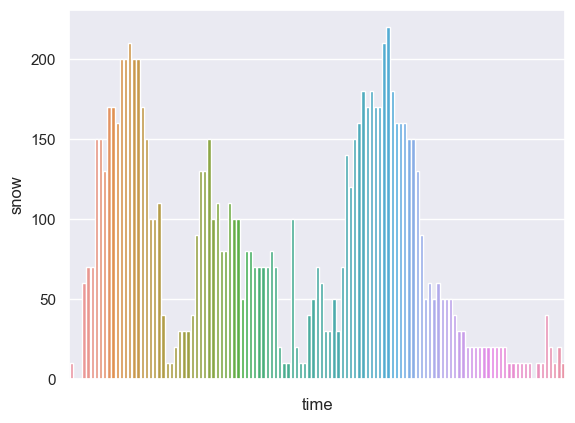

In [29]:
g1 = sns.barplot(to_plot, x="time", y="snow")
g1.set(xticklabels=[])
print()

<AxesSubplot: xlabel='day', ylabel='month'>

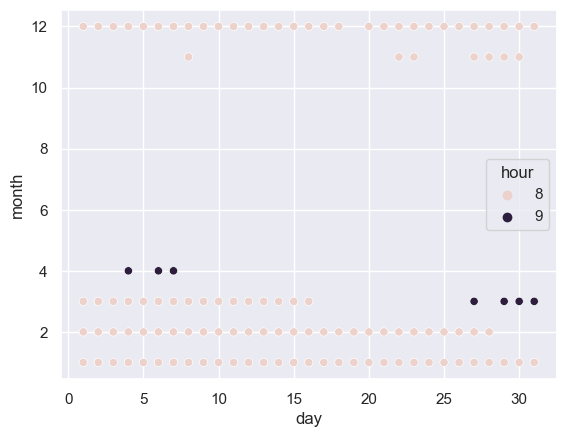

In [30]:
sns.scatterplot(to_plot, x="day", y="month", hue="hour")

<AxesSubplot: xlabel='day', ylabel='hour'>

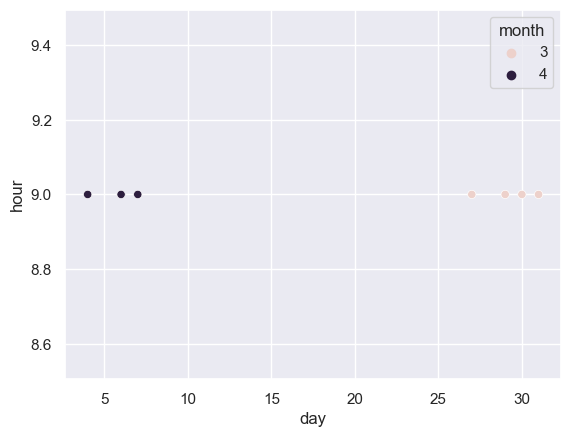

In [31]:
sns.scatterplot(to_plot[to_plot["hour"] != 8], x="day", y="hour", hue="month")

In [32]:
to_plot[to_plot["hour"] != 8]

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,consumption,year,month,day,hour,weekday,season
index,,,,,,,,,,,,,,,,,,,
4977,2022-03-27 09:00:00+03:00,-3.5,-11.9,52,NaN,10.0,330,21.6,37.000000,1024.000000,2,0.10092,1.454,2022,3,27,9,6,spring
5025,2022-03-29 09:00:00+03:00,-3.8,-6.1,84,NaN,10.0,330,7.2,16.700001,1001.000000,14,0.27697,1.419,2022,3,29,9,1,spring
5049,2022-03-30 09:00:00+03:00,-6.8,-8.7,86,NaN,40.0,210,7.2,14.800000,1005.700012,1,0.24437,1.394,2022,3,30,9,2,spring
5073,2022-03-31 09:00:00+03:00,-3.5,-6.9,77,NaN,20.0,200,3.6,11.100000,1010.099976,1,0.32356,1.403,2022,3,31,9,3,spring
5169,2022-04-04 09:00:00+03:00,0.1,-2.6,82,NaN,10.0,200,14.4,24.100000,1000.500000,4,0.10116,1.380,2022,4,4,9,0,spring
5217,2022-04-06 09:00:00+03:00,-1.6,-5.3,76,NaN,20.0,260,14.4,29.600000,990.500000,3,0.17961,1.152,2022,4,6,9,2,spring
5241,2022-04-07 09:00:00+03:00,3.3,3.0,98,NaN,10.0,190,7.2,18.500000,987.099976,7,0.15141,0.746,2022,4,7,9,3,spring


In [33]:
to_plot[~to_plot["snow"].isna() & to_plot.index.isin(np.arange(4954, 5241))]

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,consumption,year,month,day,hour,weekday,season
index,,,,,,,,,,,,,,,,,,,
4977,2022-03-27 09:00:00+03:00,-3.5,-11.9,52,NaN,10.0,330,21.6,37.000000,1024.000000,2,0.10092,1.454,2022,3,27,9,6,spring
5025,2022-03-29 09:00:00+03:00,-3.8,-6.1,84,NaN,10.0,330,7.2,16.700001,1001.000000,14,0.27697,1.419,2022,3,29,9,1,spring
5049,2022-03-30 09:00:00+03:00,-6.8,-8.7,86,NaN,40.0,210,7.2,14.800000,1005.700012,1,0.24437,1.394,2022,3,30,9,2,spring
5073,2022-03-31 09:00:00+03:00,-3.5,-6.9,77,NaN,20.0,200,3.6,11.100000,1010.099976,1,0.32356,1.403,2022,3,31,9,3,spring
5169,2022-04-04 09:00:00+03:00,0.1,-2.6,82,NaN,10.0,200,14.4,24.100000,1000.500000,4,0.10116,1.380,2022,4,4,9,0,spring
5217,2022-04-06 09:00:00+03:00,-1.6,-5.3,76,NaN,20.0,260,14.4,29.600000,990.500000,3,0.17961,1.152,2022,4,6,9,2,spring


From what I see in the data the snow variable is collected only once per day, either at 8 or 9 o'clock. It becomes 9 o'clock after the shift to summer time. 

The variable will probably be useless for our prediction, since we need only august. Still I think it might be useful to have it. If the performence of training is lacking, this is the first candidate for cleaning.

For better differentiation I will copy the measured data throughout the whole day.

**IMPORTANT**

For the following code to work I am making an assumption the data is perfect. Specifically, that there is no time input missing in the whole dataset. 

I have not check the assumption yet. It is necessary to do so.

In [34]:
# Prepare the data for further preprocessing
# Copy the snow values collected at 9th hour
## to the 8th hour of the same day

hour_cond = train["hour"] == 9
snow_cond = ~(train["snow"].isna())
combined_view = train[hour_cond & snow_cond]

train.loc[combined_view.index - 1, "snow"] = combined_view["snow"].values

In [35]:
hour_cond = train["hour"] == 8
snow_cond = ~(train["snow"].isna())
combined_view = train[hour_cond & snow_cond]

# Get indexes that need to be changed
list_of_lists_indexes_to_change = np.fromiter(
    map(lambda x: np.arange(x - 8, x + 16), combined_view.index), dtype=object
)
idxs_to_change = np.concatenate(list_of_lists_indexes_to_change).ravel()

# Get values that should be imputed at the place of indexes
values_to_impute = combined_view.loc[combined_view.index.repeat(24), "snow"].values

# Put it all together
train.loc[idxs_to_change, "snow"] = values_to_impute

In [36]:
train.loc[idxs_to_change, :].sample(n=10, random_state=111)

,time,temp,dwpt,rhum,prcp,snow,wdir,wspd,wpgt,pres,coco,el_price,consumption,year,month,day,hour,weekday,season
index,,,,,,,,,,,,,,,,,,,
3113,2022-01-08 16:00:00+02:00,-2.3,-4.3,86,NaN,70.0,160,14.4,20.400000,1008.500000,14,0.17388,1.981,2022,1,8,16,5,winter
2968,2022-01-02 15:00:00+02:00,-4.8,-6.9,85,NaN,110.0,140,14.4,25.900000,1008.700012,14,0.06519,1.194,2022,1,2,15,6,winter
5040,2022-03-30 00:00:00+03:00,-7.6,-8.4,94,NaN,40.0,240,3.6,7.400000,1004.900024,2,0.19160,1.456,2022,3,30,0,2,spring
3990,2022-02-14 05:00:00+02:00,1.2,-3.1,73,NaN,150.0,220,14.4,31.500000,1007.299988,4,0.01468,3.914,2022,2,14,5,0,winter
2812,2021-12-27 03:00:00+02:00,-7.4,-8.8,90,NaN,130.0,260,7.2,11.100000,1009.299988,14,0.09118,1.819,2021,12,27,3,0,winter
2111,2021-11-27 22:00:00+02:00,-3.3,-5.0,88,NaN,60.0,40,10.8,29.600000,999.000000,14,0.20000,0.584,2021,11,27,22,5,autumn
2233,2021-12-03 00:00:00+02:00,-4.7,-6.2,89,NaN,170.0,60,10.8,20.400000,989.599976,14,0.12709,1.871,2021,12,3,0,4,winter
2474,2021-12-13 01:00:00+02:00,1.0,0.9,99,NaN,100.0,280,7.2,11.100000,1021.099976,5,0.13197,1.555,2021,12,13,1,0,winter
4015,2022-02-15 06:00:00+02:00,1.8,-2.5,73,NaN,150.0,200,14.4,31.500000,1007.700012,4,0.09776,0.490,2022,2,15,6,1,winter


It seems my magic works!

Now let's impute the rest of NaNs with zeros.

In [37]:
train["snow"] = train["snow"].fillna(0)
train["snow"].isna().any()

False

### Correlation heatmap

/var/folders/qn/lk9fg3fs0hg9v8b7zh5lbybw0000gn/T/ipykernel_14381/1694794515.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  cov_matrix = train.corr()


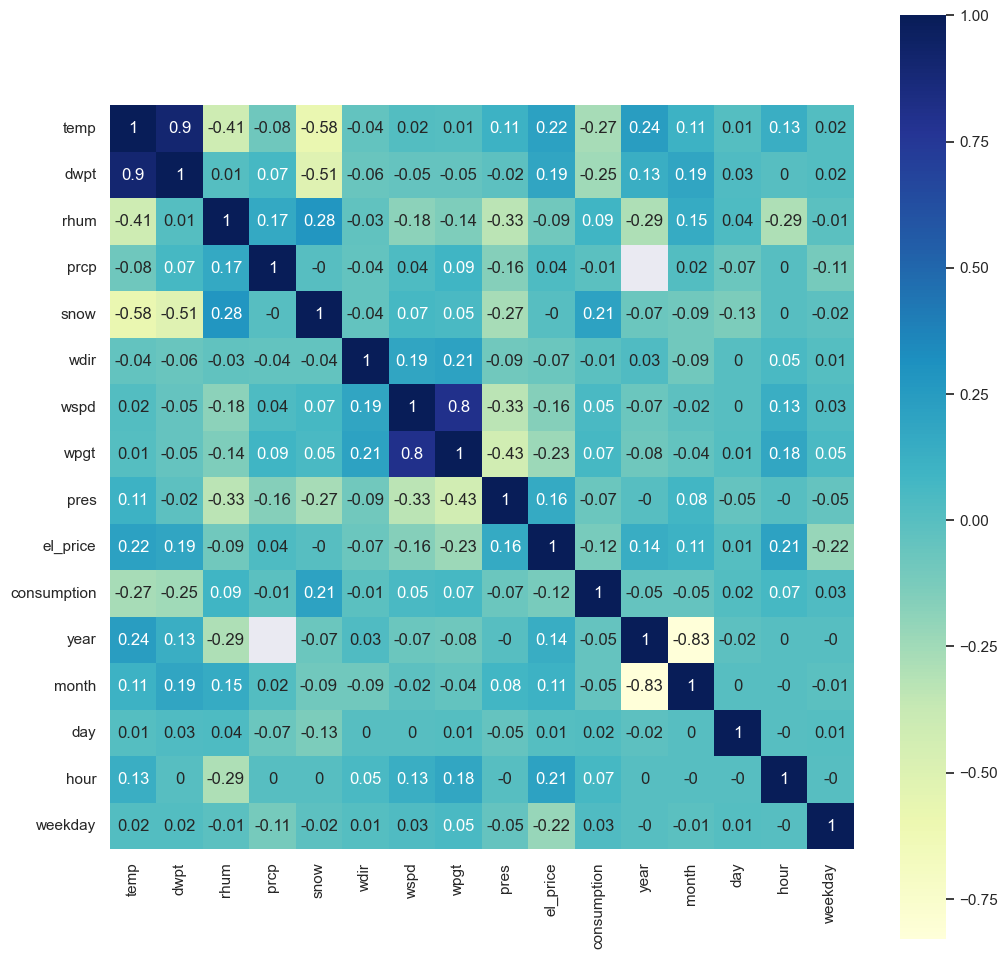

In [38]:
plt.figure(figsize=(12, 12))

cov_matrix = train.corr()
sns.heatmap(cov_matrix.round(2), annot=True, cmap="YlGnBu", square=True)
plt.show()

<AxesSubplot: >

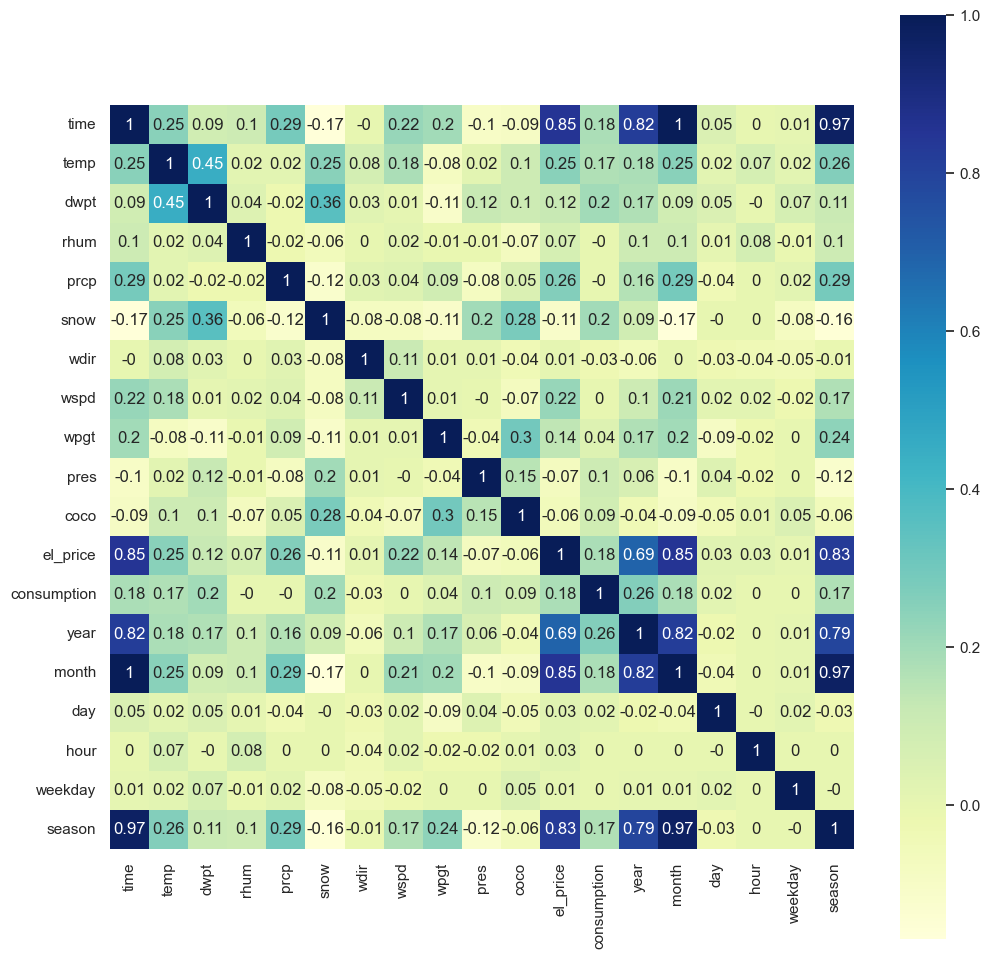

In [39]:
# Correlation method I found at https://stackoverflow.com/questions/48035381/correlation-among-multiple-categorical-variables-pandas
# Might give completely wrong information, I do not understand its asumptions
# From what I understand it transforms categorical to nominal values and computes correlation

plt.figure(figsize=(12, 12))

train_corr = train.apply(lambda x: pd.factorize(x)[0]).corr().round(2)

sns.heatmap(train_corr, annot=True, cmap="YlGnBu", square=True)

# Models

## Transformer

### Setup

Inspired by [Heiko Onnen](https://towardsdatascience.com/transformer-unleashed-deep-forecasting-of-multivariate-time-series-in-python-9ca729dac019)

In [40]:
# Temporary, repalce NaN with zeros
train.isna().any(axis=0)

time           False
temp           False
dwpt           False
rhum           False
prcp            True
snow           False
wdir           False
wspd           False
wpgt           False
pres           False
coco           False
el_price       False
consumption     True
year           False
month          False
day            False
hour           False
weekday        False
season         False
dtype: bool

In [41]:
train = train.fillna(0)
train.isna().values.any()

False

In [42]:
import os

from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.metrics import mape, rmse
from darts.models import TransformerModel
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.timeseries_generation import datetime_attribute_timeseries

/Users/macbook/.pyenv/versions/mltartu/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
LOAD = (
    False  # True = load previously saved model from disk?  False = (re)train the model
)
SAVE = "transformer.tar"  # file name to save the model under

EPOCHS = 200
INLEN = 32  # input size
FEAT = 32  # d_model = number of expected features in the inputs, up to 512
HEADS = 4  # default 8
ENCODE = 4  # encoder layers
DECODE = 4  # decoder layers
DIM_FF = 128  # dimensions of the feedforward network, default 2048
BATCH = 32  # batch size
ACTF = "relu"  # activation function, relu (default) or gelu
SCHLEARN = None  # a PyTorch learning rate scheduler; None = constant rate
LEARN = 1e-3  # learning rate
VALWAIT = 1  # epochs to wait before evaluating the loss on the test/validation set
DROPOUT = 0.1  # dropout rate
N_FC = 1  # output size

RAND = 42  # random seed
N_SAMPLES = 100  # number of times a prediction is sampled from a probabilistic model
N_JOBS = 3  # parallel processors to use;  -1 = all processors

# default quantiles for QuantileRegression
QUANTILES = [0.01, 0.1, 0.2, 0.5, 0.8, 0.9, 0.99]

FIGSIZE = (9, 6)


qL1, qL2 = 0.01, 0.10  # percentiles of predictions: lower bounds
qU1, qU2 = (
    1 - qL1,
    1 - qL2,
)  # upper bounds derived from lower bounds
label_q1 = f"{int(qU1 * 100)} / {int(qL1 * 100)} percentile band"
label_q2 = f"{int(qU2 * 100)} / {int(qL2 * 100)} percentile band"

mpath = os.path.abspath(os.getcwd()) + SAVE  # path and file name to save the model

In [44]:
model = TransformerModel(
    input_chunk_length=INLEN,
    output_chunk_length=N_FC,
    batch_size=BATCH,
    n_epochs=EPOCHS,
    model_name="Transformer_consumption",
    nr_epochs_val_period=VALWAIT,
    d_model=FEAT,
    nhead=HEADS,
    num_encoder_layers=ENCODE,
    num_decoder_layers=DECODE,
    dim_feedforward=DIM_FF,
    dropout=DROPOUT,
    activation=ACTF,
    random_state=RAND,
    likelihood=QuantileRegression(quantiles=QUANTILES),
    optimizer_kwargs={"lr": LEARN},
    add_encoders={"cyclic": {"future": ["hour", "weekday", "month"]}},
    save_checkpoints=True,
    force_reset=True,
)

In [45]:
ts_label = TimeSeries.from_times_and_values(
    times=pd.DatetimeIndex(train["time"]), values=train["consumption"]
)

# check attributes of the time series
print("components:", ts_label.components)
print("duration:", ts_label.duration)
print("frequency:", ts_label.freq)
print("frequency:", ts_label.freq_str)
print(
    "has date time index? (or else, it must have an integer index):",
    ts_label.has_datetime_index,
)
print("deterministic:", ts_label.is_deterministic)
print("univariate:", ts_label.is_univariate)

components: Index(['0'], dtype='object', name='component')
duration: 357 days 23:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: True


In [50]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8592 entries, 0 to 8591
Data columns (total 19 columns):
 #   Column       Non-Null Count  Dtype                         
---  ------       --------------  -----                         
 0   time         8592 non-null   datetime64[ns, Europe/Tallinn]
 1   temp         8592 non-null   float32                       
 2   dwpt         8592 non-null   float32                       
 3   rhum         8592 non-null   int32                         
 4   prcp         8592 non-null   float32                       
 5   snow         8592 non-null   float32                       
 6   wdir         8592 non-null   int32                         
 7   wspd         8592 non-null   float32                       
 8   wpgt         8592 non-null   float32                       
 9   pres         8592 non-null   float32                       
 10  coco         8592 non-null   category                      
 11  el_price     8592 non-null   float32       

In [63]:
from sklearn.preprocessing import LabelEncoder

le_season = LabelEncoder()

le_season.fit(train["season"])

df_transformer = train.copy(deep=True)
df_transformer["season"] = le_season.transform(df_transformer["season"])

In [61]:
df_transformer = df_transformer.drop(
    ["weekday", "month", "day", "hour", "year"], axis=1
)

ts_covF = TimeSeries.from_dataframe(
    df_transformer.loc[:, df_transformer.columns != "consumption"].set_index("time")
)

# check attributes of the time series
print("components:", ts_covF.components)
print("duration:", ts_covF.duration)
print("frequency:", ts_covF.freq)
print("frequency:", ts_covF.freq_str)
print(
    "has date time index? (or else, it must have an integer index):",
    ts_covF.has_datetime_index,
)
print("deterministic:", ts_covF.is_deterministic)
print("univariate:", ts_covF.is_univariate)

components: Index(['temp', 'dwpt', 'rhum', 'prcp', 'snow', 'wdir', 'wspd', 'wpgt', 'pres',
       'coco', 'el_price', 'season'],
      dtype='object', name='component')
duration: 357 days 23:00:00
frequency: <Hour>
frequency: H
has date time index? (or else, it must have an integer index): True
deterministic: True
univariate: False


In [67]:
SPLIT = pd.Timestamp(
    year=2022, month=8, day=17, hour=23, tzinfo=train.loc[0, "time"].tzinfo
)
SPLIT

Timestamp('2022-08-17 23:00:00+0300', tz='Europe/Tallinn')

In [72]:
ts_train_label, ts_val_label = ts_label.split_after(SPLIT)
print("training start:", ts_train_label.start_time())
print("training end:", ts_train_label.end_time())
print("training duration:", ts_train_label.duration)
print("val start:", ts_val_label.start_time())
print("val end:", ts_val_label.end_time())
print("val duration:", ts_val_label.duration)


scaler_label = Scaler()
scaler_label.fit_transform(ts_train_label)
ts_ttrain = scaler_label.transform(ts_train_label)
ts_tval = scaler_label.transform(ts_val_label)
ts_tall = scaler_label.transform(ts_train_label)

training start: 2021-09-01 00:00:00+03:00
training end: 2022-08-17 23:00:00+03:00
training duration: 350 days 23:00:00
val start: 2022-08-18 00:00:00+03:00
val end: 2022-08-24 23:00:00+03:00
val duration: 6 days 23:00:00


In [74]:
covF_train, covF_val = ts_covF.split_after(SPLIT)

print("training start:", covF_train.start_time())
print("training end:", covF_train.end_time())
print("training duration:", covF_train.duration)
print("val start:", covF_val.start_time())
print("val end:", covF_val.end_time())
print("val duration:", covF_val.duration)

scalerF = Scaler()
scalerF.fit(covF_train)
covF_ttrain = scalerF.transform(covF_train)
covF_tval = scalerF.transform(covF_val)
covF_tall = scalerF.transform(ts_covF)

training start: 2021-09-01 00:00:00+03:00
training end: 2022-08-17 23:00:00+03:00
training duration: 350 days 23:00:00
val start: 2022-08-18 00:00:00+03:00
val end: 2022-08-24 23:00:00+03:00
val duration: 6 days 23:00:00


In [76]:
covT = datetime_attribute_timeseries(ts_label.time_index, attribute="hour", one_hot=False)
covT = covT.stack(
    datetime_attribute_timeseries(
        covT.time_index, attribute="day_of_week", one_hot=False
    )
)
covT = covT.stack(
    datetime_attribute_timeseries(covT.time_index, attribute="month", one_hot=False)
)
covT = covT.stack(
    datetime_attribute_timeseries(covT.time_index, attribute="year", one_hot=False)
)

covT = covT.add_holidays(country_code="EE")
covT = covT.astype(np.float32)

covT_train, covT_val = covT.split_after(SPLIT)

scalerT = Scaler()
scalerT.fit(covT_train)
covT_ttrain = scalerT.transform(covT_train)
covT_tval = scalerT.transform(covT_val)
covT_t = scalerT.transform(covT)

covT_t = covT_t.astype(np.float32)

In [ ]:
# ts_train = train.head(len(train) - 24 * 7).copy(deep=True)
# ts_val = train.tail(24 * 7).copy(deep=True)

# ts_train_labels = train_labels[0 : len(train) - 24 * 7]
# ts_val_labels = train_labels[len(train) - 24 * 7 : ]

# len(ts_train) == len(ts_train_labels)

In [247]:
if LOAD:
    print("have loaded a previously saved model from disk:" + mpath)
    model = TransformerModel.load_model(mpath)  # load previously model from disk
else:
    model.fit(df_transformer, past_covariates=cov_t, verbose=True)
    print("have saved the model after training:", mpath)
    model.save_model(mpath)

NameError: name 'cov_t' is not defined

## Data modification

In [31]:
# USE the code we wrote above
train = train.drop(["consumption"], axis=1)

train_no_time = train.drop(["time", "coco", "season"], axis=1)
test_no_time = test.drop(["time", "coco"], axis=1)
test_no_time, train_no_time, labels = replaceNanWithZero(
    test_no_time, train_no_time, train_labels
)

PCA_Performance(train_no_time, test_no_time)

Retained 0.5 of variance with 1 number of features
Retained 0.6 of variance with 1 number of features
Retained 0.75 of variance with 2 number of features
Retained 0.8 of variance with 2 number of features
Retained 0.85 of variance with 2 number of features
Retained 0.9 of variance with 2 number of features
Retained 0.95 of variance with 3 number of features
Retained 0.96 of variance with 4 number of features
Retained 0.97 of variance with 4 number of features
Retained 0.98 of variance with 5 number of features
Retained 0.99 of variance with 7 number of features
